<a href="https://colab.research.google.com/github/Praise-Atadja/heart-disease-analysis/blob/main/heart_disease_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **PROJECT NAME:**

# Heart Disease Dataset Analysis

---
(This project is to use unsupervised learning techniques to cluster patients based on their medical history and identify risk factors associated with heart disease.)

(The task is to analyze a dataset of medical records to identify patients with high risk of developing heart disease.)

# Install necessary libraries

In [1]:
pip install ucimlrepo

In [5]:
pip install scikit-learn

# Import necessary libraries

In [3]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score


# 1. Load Datasets

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

# 2. Preprocess Cleveland data

In [8]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
    "exang", "oldpeak", "slope", "ca", "thal", "target"
]
df = pd.read_csv(url, header=None, names=column_names)

# Perform EDA
print(df.head())
print(df.info())
print(df.describe())



    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  target  
0    3.0  0.0  6.0       0  
1    2.0  3.0  3.0       2  
2    2.0  2.0  7.0       1  
3    3.0  0.0  3.0       0  
4    1.0  0.0  3.0       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-n

In [14]:
# Handle missing values
df = df.replace('?', np.nan)
df = df.dropna()

# Convert categorical variables to numeric
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
for feature in categorical_features:
    # Attempt to convert to integers, handling potential errors
    try:
        df[feature] = df[feature].astype(int)
    except ValueError:
        print(f"Could not convert column '{feature}' to integers. Investigating values...")
        print(df[feature].unique())  # Print unique values in the problematic column


# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('target', axis=1))

# Create a DataFrame with the scaled features
df_scaled = pd.DataFrame(scaled_features, columns=df.columns[:-1])

# Add the target variable
df_scaled['target'] = df['target']

# Split the data into features and target
X = df_scaled.drop('target', axis=1)
y = df_scaled['target']

Could not convert column 'ca' to integers. Investigating values...
['0.0' '3.0' '2.0' '1.0']
Could not convert column 'thal' to integers. Investigating values...
['6.0' '3.0' '7.0']


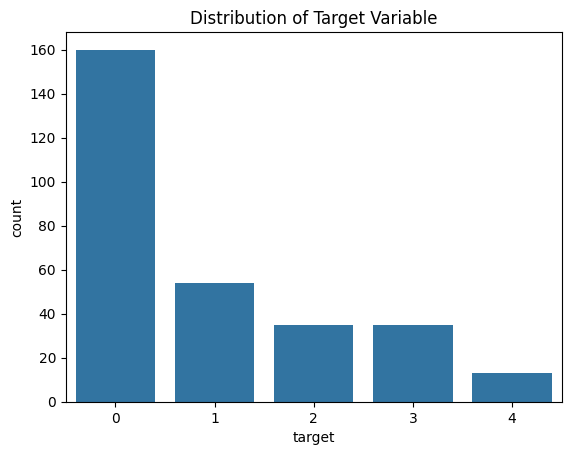

In [17]:
# Visualize the distribution of target variable
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable')
plt.show()



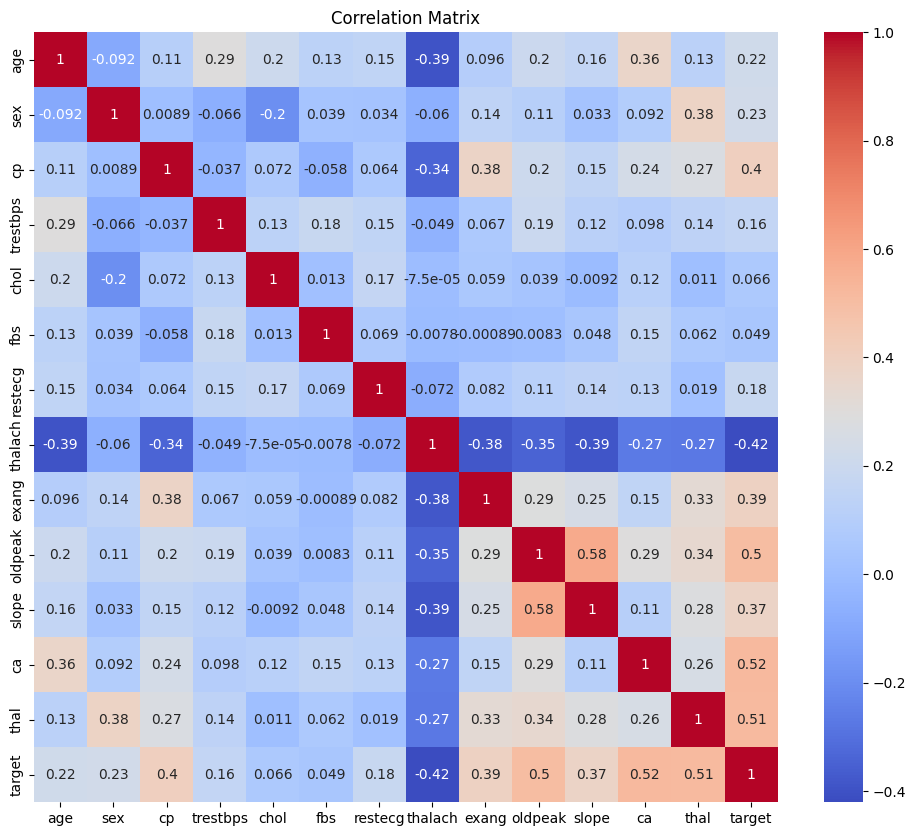

In [13]:
# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 3. Apply Clustering Algorithms

Apply K-means clustering


In [18]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Apply Hierarchical clustering

In [ ]:
# Apply Hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_labels = hierarchical.fit_predict(df_scaled)

Apply DBSCAN clustering

In [ ]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)

# 4. Visualize the Clusters

PCA visualization

In [ ]:
# PCA visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
plt.title('K-means Clustering with PCA')
plt.show()

t-SNE visualization

In [ ]:
# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
plt.title('K-means Clustering with t-SNE')
plt.show()

# 5. Gaussian Mixture Models

In [ ]:
# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(df_scaled)

# 6. Evaluate Clustering Performance


Applying silhouette score and Davies-Bouldin index.


In [ ]:
# Evaluate K-means
kmeans_silhouette = silhouette_score(df_scaled, kmeans_labels)
kmeans_davies_bouldin = davies_bouldin_score(df_scaled, kmeans_labels)

# Evaluate Hierarchical clustering
hierarchical_silhouette = silhouette_score(df_scaled, hierarchical_labels)
hierarchical_davies_bouldin = davies_bouldin_score(df_scaled, hierarchical_labels)

# Evaluate DBSCAN
dbscan_silhouette = silhouette_score(df_scaled, dbscan_labels)
dbscan_davies_bouldin = davies_bouldin_score(df_scaled, dbscan_labels)

# Evaluate GMM
gmm_silhouette = silhouette_score(df_scaled, gmm_labels)
gmm_davies_bouldin = davies_bouldin_score(df_scaled, gmm_labels)

print(f"K-means Silhouette Score: {kmeans_silhouette}, Davies-Bouldin Score: {kmeans_davies_bouldin}")
print(f"Hierarchical Silhouette Score: {hierarchical_silhouette}, Davies-Bouldin Score: {hierarchical_davies_bouldin}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}, Davies-Bouldin Score: {dbscan_davies_bouldin}")
print(f"GMM Silhouette Score: {gmm_silhouette}, Davies-Bouldin Score: {gmm_davies_bouldin}")


# 7. Compare Clustering Algorithms

In [ ]:
# Summarize the results
results = {
    'Algorithm': ['K-means', 'Hierarchical', 'DBSCAN', 'GMM'],
    'Silhouette Score': [kmeans_silhouette, hierarchical_silhouette, dbscan_silhouette, gmm_silhouette],
    'Davies-Bouldin Score': [kmeans_davies_bouldin, hierarchical_davies_bouldin, dbscan_davies_bouldin, gmm_davies_bouldin]
}

results_df = pd.DataFrame(results)
print(results_df)
